# Fama-French Randomization with FM Regressions

By Nicolas Harvie

Objective of this project is to see the impact of randomization in decimals of the Fama-French factors on the Fama-Macbeth regression that is used to assess the significance of new anomalies.
***

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_datareader as pdr
from IPython.display import Image
import seaborn as sns
import glob

import warnings
warnings.filterwarnings('ignore')

***
## Setup
Loading three datasets:
1. FF Monthly Factors
2. Monthly returns
3. Monthly risk premia of additional factors

In [2]:
# Importing the 5 Factors 
FF_five_with_rf= pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1900')[0]
FF_three_with_rf = FF_five_with_rf.drop(columns={'RMW', 'CMA'})

In [4]:
# Loading Benchmark Cross-Section from CRSP
crsp_mret = pd.read_csv('../data/returns.csv', parse_dates=['MthCalDt'], index_col = 'MthCalDt')
crsp_mret.index = crsp_mret.index.to_period('M')

# DataFrame containing the premia for new predictors
chen_factors = pd.read_csv('../data/chen_predictors.csv', parse_dates=['date'], index_col='date')
chen_factors.index = chen_factors.index.to_period('M')

***
## Merging
Here we merge de returns dataframe with the FF Factors and the additional factor we want to test

In [52]:
# Code Function that merges the adequate FF specification, and the adequate factor 

def merge_df(ff_df, ret_df, factor):
    '''
    Function that merges all the adequate DFs for our analysis 
    Parameters: 
    ff_df: Fama-French Specification 
    ret_df: Returns DF
    factor: The Adequate Factor we want to incorporate into the FM2 
    '''
    
    # Merging Returns and adequate FF specification 
    merged_df = pd.merge(ret_df, ff_df, left_index=True, right_index=True)

    # Merging previous dataframe to the new factors
    merged_df = pd.merge(merged_df, chen_factors[factor], left_index=True, right_index=True)

    # Calculation of ExRet
    merged_df['ExRet'] = (merged_df['MthRet'] - (merged_df['RF'] / 100))

    # Bit of Cleaning
    merged_df = merged_df.drop(columns={'RF'})
    merged_df.insert(3, 'ExRet', merged_df.pop('ExRet'))    
    
    return merged_df 


***
## Fama-Macbeth Outline

The Fama-Macbeth regression is a two-step procedure, where in the first step, we estimate the factor loadings for each firm using time-series regression, and in the second step, we estimate the risk premia for each factor using cross-sectional regression.

In [55]:
# Group data by asset
groups = merge_df(ff_df = FF_three_with_rf, ret_df=crsp_mret, factor='Accruals').groupby('PERMNO')

In [56]:
###=== FIRST STAGE FUNCTION ===###

def reg_func(group):
    """
    Function that returns the loadings for each factors for each asset (PERMNO)

    Arguments: 
    group: Refers to the dataframe of the asset in question 

    Returns:
    An len(PERMNO.unique())x len(factor) DF returns the loadings for each factors for each asset (PERMNO)
    """

    # Applying randomness to the FF Factors if desired
    group[['Mkt-RF', 'SMB', 'HML']] = group[['Mkt-RF', 'SMB', 'HML']] + np.random.uniform(-0.005, 0.005, size=group[['Mkt-RF', 'SMB', 'HML']].shape)
    
    # Setting an X Value that includes constant and new factor
    X = sm.add_constant(group.iloc[:, 4:])
    
    # Regression
    model = sm.OLS(group['ExRet'], X)
    results = model.fit()
    
    # Returns the results
    return results.params[0:]

In [57]:
# Base scenario 
base = groups.apply(reg_func).unstack()

In [47]:
###=== SIMULATION FUNCTION ===#
# Simulations are already made, see 'simulations' folder 

# def make_simulations(n):
#     """
#     Function that runs a number of simulations for alternative FF Randomized DFs to give alternative beta coefficients 
#     """
#     d = {}
    
#     for i in range(n):
#         d[i] = groups.apply(reg_func)

#     return d

In [11]:
def grab_simulations():
    folder_path = '../data/simulations'

    # Specify the file extension or pattern to match
    file_extension = '*.csv'  # Change this to match the file extension of your dataframes

    # Get a list of file paths that match the specified pattern
    file_paths = glob.glob(f"{folder_path}/{file_extension}")

    # Create an empty list to store the dataframes
    dataframes = []

    # Iterate over each file path and read the dataframe
    for file_path in file_paths:
        df = pd.read_csv(file_path)  # Adjust this if your dataframes are in a different format
        dataframes.append(df)
    return dataframes

In [12]:
simulations = grab_simulations()

## Fama-Macbeth Second Step

In [58]:
# Merging the FF and Ret DF
all_df = merge_df(ff_df = FF_three_with_rf, ret_df=crsp_mret, factor='Accruals')

In [59]:
###=== FM SECOND STAGE FOR BASE SCENARIO ===###

# Merging the DFs
base_merged_2sls_df = pd.merge(all_df, base, left_on='PERMNO', right_index=True)
base_merged_2sls_df = base_merged_2sls_df.rename(columns={'Mkt-RF_y': 'Mkt-RF', 'SMB_y': 'SMB', 'HML_y': 'HML', 'Accruals_y': 'Accruals'})[['PERMNO', 'ExRet', 'Mkt-RF', 'SMB', 'HML', 'Accruals']]

# Set the Variables 
Y = base_merged_2sls_df['ExRet']
X = sm.add_constant(base_merged_2sls_df[['Mkt-RF', 'SMB', 'HML', 'Accruals']])

# Perform cross-sectional regression
res = sm.OLS(Y, X, missing='drop').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ExRet   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                 8.128e+04
Date:                Wed, 26 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:18:33   Log-Likelihood:             1.5869e+06
No. Observations:             3825220   AIC:                        -3.174e+06
Df Residuals:                 3825215   BIC:                        -3.174e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   9.78e-05      1.463      0.144   -4.86e-05       0.000
Mkt-RF         0.0103   1.82e-05    569.833      0.000       0.010       0.010
SMB            0.0732      0.005     13.697      0.000       0.063       0.084
HML            0.0785      0.004     17.865      0.000       0.070       0.087
Accruals       0.0243      0.005      5.154      0.000       0.015       0.034
==============================================================================
Omnibus:                  5544651.053   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      24843684861.071
Skew:                           7.788   Prob(JB):                         0.00
Kurtosis:                     397.500   Cond. No.                         327.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
###=== FM SECOND STAGE FOR SIMULATIONS ===###

# Creating dictionary to hold the values
d = {}

# Loop for a number of simulations 
for i in range(len(simulations)):
    merged_2sls_df = pd.merge(all_df, simulations[i], left_on='PERMNO', right_on='PERMNO')
    merged_2sls_df = merged_2sls_df.rename(columns={'Mkt-RF_y': 'Mkt-RF', 'SMB_y': 'SMB', 'HML_y': 'HML', 'Accruals_y': 'Accruals'})[['PERMNO', 'ExRet', 'Mkt-RF', 'SMB', 'HML', 'Accruals']]
    
    # Set the Variables 
    Y = merged_2sls_df['ExRet']
    X = sm.add_constant(merged_2sls_df[['Mkt-RF', 'SMB', 'HML', 'Accruals']])

    # Perform cross-sectional regression
    res = sm.OLS(Y, X, missing='drop').fit()

    # return the parameters
    d[i] = res.tvalues[0:]


In [70]:
# Converting to DF 
distributions_tvals = pd.DataFrame(d)

<AxesSubplot: xlabel='Accruals', ylabel='Density'>

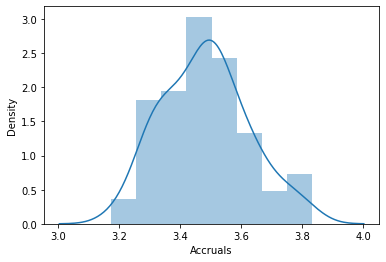

In [71]:
sns.distplot(distributions_tvals.T['Accruals'])

## Simulation to CSV

In [ ]:
# for i in range(100):
#     simulations[i].unstack().to_csv(f'/Users/nicolasharvie/Documents/HEC_Work/Empirical_Finance/Research/OEF/CrossSection-python/Main/Codebase/Randomization/Simulations/Simulation{i}.csv')
    